## **SVM Experiments**
The following is the codebase we utilized for the Support Vector Machine portion of our experiment.

General imports and functions are to be found at the top of the notebook. The execution code can be found beginning with the filesystem mount towards the bottom.

Set up the workspace with the following imports:

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load, dump
from tqdm.auto import tqdm

Step 1: Load and prepare the dataset for SVM/PCA

In [2]:
def load_and_prepare_data(features_path, tracks_path):
    """
    Load music features and track metadata; prep for decade classification
    """
    def read_features_file(file_path):
        df = pd.read_csv(file_path, header=[0, 1, 2], low_memory=False)

        df.columns = ['_'.join(str(col) for col in col_tuple if col).strip()
                      for col_tuple in df.columns.values]
        return df

    print("Loading features data...")
    features_df = read_features_file(features_path)

    features_df = features_df.reset_index()
    features_df.rename(columns={'index': 'track_id'}, inplace=True)
    print(features_df.head())
    print(features_df.columns)
    features_df = features_df.drop('feature_statistics_number', axis=1)


    print("Loading tracks data...")
    tracks_df = pd.read_csv(tracks_path, low_memory=False)
    print(tracks_df.head())
    print(tracks_df.columns)

    if 'album.2' in tracks_df.columns:
        tracks_df['year'] = pd.to_datetime(tracks_df['album.2'], errors='coerce').dt.year
    else:
        date_cols = [col for col in tracks_df.columns if 'date_released' in str(col).lower()]
        if date_cols:
            tracks_df['year'] = pd.to_datetime(tracks_df[date_cols[0]], errors='coerce').dt.year
        else:
            tracks_df['year'] = pd.to_datetime(tracks_df['track.3'], errors='coerce').dt.year

    tracks_df['decade'] = (tracks_df['year'] // 10) * 10

    tracks_df = tracks_df.dropna(subset=['decade'])

    if 'track_id' not in tracks_df.columns:
        if 'Unnamed: 0' in tracks_df.columns:
            tracks_df = tracks_df[2:].copy()
            tracks_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
            tracks_df['track_id'] = pd.to_numeric(tracks_df['track_id'], errors='coerce')

    tracks_df = tracks_df.dropna(subset=['track_id'])

    print("Merging datasets...")
    print(f"Features shape before merge: {features_df.shape}")
    print(f"Tracks shape before merge: {tracks_df.shape}")
    print(f"Feature columns: {features_df.columns[:5]}...")
    print(f"Tracks columns being used: track_id, decade")

    features_df['track_id'] = features_df['track_id'].astype(int)
    tracks_df['track_id'] = tracks_df['track_id'].astype(int)

    merged_df = pd.merge(features_df, tracks_df[['track_id', 'decade']],
                         on='track_id', how='inner')

    print(f"Merged dataframe shape: {merged_df.shape}")

    merged_df = merged_df.dropna(subset=['decade'])

    merged_df['decade'] = merged_df['decade'].astype(int)

    feature_cols = [col for col in merged_df.columns if col != 'track_id' and col != 'decade']
    X = merged_df[feature_cols]
    y = merged_df['decade']

    print(f"Total samples: {len(X)}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Decade distribution: {y.value_counts().sort_index()}")

    return X, y

Step 2: SVM with RBF kernel, using a one vs one approach

In [3]:
def train_svm(X, y, max_samples_per_decade=2000, experiment=5):
    """
    trains SVM, according to experimental features desired
    """

    print("Processing features...")
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    X_balanced = None
    y_balanced = None

    class_counts = y.value_counts()
    print("Original class distribution:")
    print(class_counts)

    def group_decades(decade):
        if decade < 1950:
            return 1940  #all pre-1950 are "1940s and earlier"
        elif 1950 <= decade < 1970:
            return 1960  #50/60s together
        elif 1970 <= decade < 1990:
            return 1980  #70/80s together
        else:
            return decade

    y_grouped = y.apply(group_decades)

    small_classes = class_counts[class_counts < 2].index.tolist()
    if small_classes:
        print(f"Warning: Removing {len(small_classes)} decades with fewer than 2 samples: {small_classes}")
        valid_samples = ~y_grouped.isin(small_classes)
        X_filtered = X_imputed[valid_samples]
        y_filtered = y_grouped[valid_samples]
    else:
        X_filtered = X_imputed
        y_filtered = y_grouped


    print("After grouping, class distribution:")
    print(y_filtered.value_counts())
    print(f"Limiting to {max_samples_per_decade} samples per decade group...")
    balanced_indices = []
    decades = y_filtered.unique()

    for decade in decades:
        decade_indices = y_filtered[y_filtered == decade].index
        if len(decade_indices) > max_samples_per_decade:
            sampled_indices = np.random.choice(decade_indices, max_samples_per_decade, replace=False)
            balanced_indices.extend(sampled_indices)
        else:
            balanced_indices.extend(decade_indices)

    X_balanced = X_filtered.loc[balanced_indices]
    y_balanced = y_filtered.loc[balanced_indices]

    #FEATURE ENGINEERING SECTION
    if (experiment >= 3):

      print("Engineering additional features...")

      def engineer_music_features(X):
          """creates additional features"""
          X_new = X.copy()

          chroma_features = [col for col in X.columns if 'chroma' in col.lower()]
          mfcc_features = [col for col in X.columns if 'mfcc' in col.lower()]
          spectral_features = [col for col in X.columns if 'spectral' in col.lower()]

          if len(chroma_features) > 0 and len(mfcc_features) > 0:
              for c_feat in chroma_features[:3]:
                  for m_feat in mfcc_features[:3]:
                      X_new[f'ratio_c{c_feat}_m{m_feat}'] = X[c_feat] / (X[m_feat] + 1e-6)

          if len(mfcc_features) > 0:
              X_new['mfcc_mean'] = X[mfcc_features].mean(axis=1)
              X_new['mfcc_std'] = X[mfcc_features].std(axis=1)

          if len(spectral_features) > 0:
              X_new['spectral_mean'] = X[spectral_features].mean(axis=1)
              X_new['spectral_std'] = X[spectral_features].std(axis=1)

          return X_new

      X_engineered = engineer_music_features(X_filtered)
      print(f"Original features: {X_filtered.shape[1]}, After engineering: {X_engineered.shape[1]}")
      X_balanced = X_engineered

    print("Balanced class distribution:")
    print(y_balanced.value_counts())

    print("Splitting data into training and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced,
        test_size=0.2,
        random_state=42,
        stratify=y_balanced
    )


    print("Performing initial feature selection...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    k_values = [60, 100, 200, 300]
    k_results = []

    with tqdm(total=len(k_values), desc="Initial Feature Selection") as pbar:
        for k in k_values:
            selector = SelectKBest(f_classif, k=k)
            X_train_selected = selector.fit_transform(X_train_scaled, y_train)
            X_test_selected = selector.transform(X_test_scaled)

            start_time = time.time()
            model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
            model.fit(X_train_selected, y_train)
            train_time = time.time() - start_time

            train_score = model.score(X_train_selected, y_train)
            test_score = model.score(X_test_selected, y_test)

            k_results.append({
                'k': k,
                'train_score': train_score,
                'test_score': test_score,
                'train_time': train_time
            })

            pbar.set_postfix({
                'k': k,
                'train_acc': f"{train_score:.4f}",
                'test_acc': f"{test_score:.4f}",
                'time': f"{train_time:.2f}s"
            })
            pbar.update(1)

    best_k = max(k_results, key=lambda x: x['test_score'])['k']
    print(f"Best initial k: {best_k} features")
    best_score = -1
    best_params = None
    best_model = None
    results = []


    if experiment < 4:
      print("Executing grid search with feature selection...")

      #MULTIPLE KERNELS SETUP
      if experiment >= 2:
          kernels = ['rbf', 'poly', 'sigmoid']
      else:
          kernels = ['rbf']

      if experiment >= 3:
          feature_nums = [best_k+50, best_k, best_k+50]
      else:
          feature_nums = [best_k]

      param_grid = {
          'feature_selection__k': feature_nums,
          'svm__C': [0.1, 1.0, 10.0, 100.0],
          'svm__kernel': kernels,
          'svm__gamma': ['scale', 0.01, 0.1, 1.0],
          'svm__class_weight': ['balanced']
      }

      pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('feature_selection', SelectKBest(f_classif)),
          ('svm', SVC(kernel='rbf', probability=True, decision_function_shape='ovo'))
      ])

      print("Performing grid search with feature selection...")
      param_combinations = list(ParameterGrid(param_grid))

      with tqdm(total=len(param_combinations), desc="Parameter Combinations") as pbar:
          for i, params in enumerate(param_combinations):
              pipeline.set_params(**params)

              start_time = time.time()
              pipeline.fit(X_train, y_train)
              fit_time = time.time() - start_time

              train_score = pipeline.score(X_train, y_train)
              test_score = pipeline.score(X_test, y_test)

              results.append({
                  'params': params,
                  'train_score': train_score,
                  'test_score': test_score,
                  'fit_time': fit_time
              })

              pbar.set_postfix({
                  'C': params['svm__C'],
                  'gamma': params['svm__gamma'],
                  'train_acc': f"{train_score:.4f}",
                  'test_acc': f"{test_score:.4f}",
                  'time': f"{fit_time:.2f}s"
              })

              if test_score > best_score:
                  best_score = test_score
                  best_params = params
                  best_model = pipeline

              pbar.update(1)

      print("\nGrid search results summary:")
      results_df = pd.DataFrame([
          {
              'C': r['params']['svm__C'],
              'gamma': r['params']['svm__gamma'],
              'k': r['params']['feature_selection__k'],
              'train_score': r['train_score'],
              'test_score': r['test_score'],
              'fit_time': r['fit_time']
          }
          for r in results
      ])

      print(results_df.sort_values('test_score', ascending=False).head(5))
      print("\nBest parameters:", best_params)

    else:
      #EXPERIMENT 4 - ENSEMBLE

      print("Performing feature selection...")
      selector = SelectKBest(f_classif, k=best_k)
      X_train_selected = selector.fit_transform(X_train_scaled, y_train)
      X_test_selected = selector.transform(X_test_scaled)
      print("Training SVM models for ensemble experiment...")
      svm_rbf = SVC(kernel='rbf', C=10.0, gamma=0.01, probability=True, class_weight='balanced')
      svm_rbf.fit(X_train_selected, y_train)

      svm_poly = SVC(kernel='poly', C=10.0, gamma=0.01, probability=True, class_weight='balanced')
      svm_poly.fit(X_train_selected, y_train)

      svm_sigmoid = SVC(kernel='sigmoid', C=10.0, gamma=0.01, probability=True, class_weight='balanced')
      svm_sigmoid.fit(X_train_selected, y_train)

      svm_linear = SVC(kernel='linear', C=1.0, probability=True, class_weight='balanced')
      svm_linear.fit(X_train_selected, y_train)

      print("Creating ensemble...")
      ensemble = VotingClassifier(
          estimators=[
              ('svm_rbf', svm_rbf),
              ('svm_poly', svm_poly),
              ('svm_sigmoid', svm_sigmoid),
              ('svm_linear', svm_linear)
          ],
          voting='soft'
      )

      ensemble.fit(X_train_selected, y_train)

      print("Evaluating models...")
      svm_rbf_score = svm_rbf.score(X_test_selected, y_test)
      svm_poly_score = svm_poly.score(X_test_selected, y_test)
      svm_sigmoid_score = svm_sigmoid.score(X_test_selected, y_test)
      svm_linear_score = svm_linear.score(X_test_selected, y_test)
      ensemble_score = ensemble.score(X_test_selected, y_test)

      print(f"SVM RBF Accuracy: {svm_rbf_score:.4f}")
      print(f"SVM Poly Accuracy: {svm_poly_score:.4f}")
      print(f"SVM Sigmoid Accuracy: {svm_sigmoid_score:.4f}")
      print(f"SVM Linear Accuracy: {svm_linear_score:.4f}")
      print(f"Ensemble Accuracy: {ensemble_score:.4f}")

      best_score = max(svm_rbf_score, svm_poly_score, svm_sigmoid_score, svm_linear_score, ensemble_score)

      if best_score == ensemble_score:
          print("Ensemble is the best model!")
          y_pred = ensemble.predict(X_test_selected)
          best_model = {
              'type': 'ensemble',
              'scaler': scaler,
              'selector': selector,
              'model': ensemble
          }
      elif best_score == svm_rbf_score:
          print("SVM RBF is the best model!")
          y_pred = svm_rbf.predict(X_test_selected)
          best_model = {
              'type': 'svm',
              'scaler': scaler,
              'selector': selector,
              'model': svm_rbf
          }
      elif best_score == svm_sigmoid_score:
          print("SVM Sigmoid is the best model!")
          y_pred = svm_sigmoid.predict(X_test_selected)
          best_model = {
              'type': 'svm',
              'scaler': scaler,
              'selector': selector,
              'model': svm_sigmoid
          }
      elif best_score == svm_linear_score:
          print("SVM Linear is the best model!")
          y_pred = svm_linear.predict(X_test_selected)
          best_model = {
              'type': 'svm',
              'scaler': scaler,
              'selector': selector,
              'model': svm_linear
          }
      else:
          print("SVM Poly is the best model!")
          y_pred = svm_poly.predict(X_test_selected)
          best_model = {
              'type': 'svm',
              'scaler': scaler,
              'selector': selector,
              'model': svm_poly
          }

    print(f"Best score: {best_score:.4f}")

    print("Generating final predictions...")
    y_pred = best_model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Generating confusion matrix...")
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(np.unique(y_test)),
                yticklabels=sorted(np.unique(y_test)))
    plt.xlabel('Predicted Decade')
    plt.ylabel('True Decade')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix_feature_selection.png')

    return best_model

At the stage at which we added experiment 5, we did not wish to meddle with the code from #1-#4 to redo the data preprocessing pipeline to handle both types of data. Hence the repetitive nature of the code (not exactly adherent to DRY principles...).

In [14]:
def train_svm_experiment_5_6(X, y, max_samples_per_year=2000, use_ensemble=False):
    """
    trains SVM to classify songs by individual year (2009-2013)
    """
    balanced_indices = []
    years = y.unique()

    for year in years:
        year_indices = y[y == year].index
        if len(year_indices) > max_samples_per_year:
            sampled_indices = np.random.choice(year_indices, max_samples_per_year, replace=False)
            balanced_indices.extend(sampled_indices)
        else:
            balanced_indices.extend(year_indices)

    #remove years with too small values
    X_balanced = X.loc[balanced_indices]
    y_balanced = y.loc[balanced_indices]
    year_counts = y_balanced.value_counts()
    valid_years = year_counts[year_counts >= 2].index
    X_balanced = X_balanced[y_balanced.isin(valid_years)]
    y_balanced = y_balanced[y_balanced.isin(valid_years)]


    print("More balanced year distribution:")
    print(y_balanced.value_counts().sort_index())

    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X_balanced), columns=X_balanced.columns)

    print("Splitting data into training and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y_balanced,
        test_size=0.2,
        random_state=42,
        stratify=y_balanced
    )

    print("Scaling features; performing feature selection...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    k_values = [60, 100, 200, 300]
    k_results = []

    with tqdm(total=len(k_values), desc="Feature Selection") as pbar:
        for k in k_values:
            selector = SelectKBest(f_classif, k=k)
            X_train_selected = selector.fit_transform(X_train_scaled, y_train)
            X_test_selected = selector.transform(X_test_scaled)

            start_time = time.time()
            model = SVC(kernel='rbf', C=10.0, gamma='scale', class_weight='balanced')
            model.fit(X_train_selected, y_train)
            train_time = time.time() - start_time

            train_score = model.score(X_train_selected, y_train)
            test_score = model.score(X_test_selected, y_test)

            k_results.append({
                'k': k,
                'train_score': train_score,
                'test_score': test_score,
                'train_time': train_time
            })

            pbar.set_postfix({
                'k': k,
                'train_acc': f"{train_score:.4f}",
                'test_acc': f"{test_score:.4f}",
                'time': f"{train_time:.2f}s"
            })
            pbar.update(1)

    best_k = max(k_results, key=lambda x: x['test_score'])['k']
    print(f"Best k: {best_k} features")

    print(f"Training model with {best_k} features...")
    final_selector = SelectKBest(f_classif, k=best_k)
    X_train_final = final_selector.fit_transform(X_train_scaled, y_train)
    X_test_final = final_selector.transform(X_test_scaled)

    if use_ensemble:
        print("Training ensemble of SVM models with different kernels...")

        svm_rbf = SVC(kernel='rbf', C=10.0, gamma=0.01, probability=True, class_weight='balanced')
        svm_rbf.fit(X_train_final, y_train)

        svm_poly = SVC(kernel='poly', C=10.0, degree=3, gamma=0.01, probability=True, class_weight='balanced')
        svm_poly.fit(X_train_final, y_train)

        svm_sigmoid = SVC(kernel='sigmoid', C=1.0, gamma=0.1, probability=True, class_weight='balanced')
        svm_sigmoid.fit(X_train_final, y_train)

        svm_linear = SVC(kernel='linear', C=1.0, probability=True, class_weight='balanced')
        svm_linear.fit(X_train_final, y_train)

        ensemble = VotingClassifier(
            estimators=[
                ('svm_rbf', svm_rbf),
                ('svm_poly', svm_poly),
                ('svm_sigmoid', svm_sigmoid),
                ('svm_linear', svm_linear)
            ],
            voting='soft'
        )

        ensemble.fit(X_train_final, y_train)

        print("\nEvaluating individual models:")
        svm_rbf_score = svm_rbf.score(X_test_final, y_test)
        svm_poly_score = svm_poly.score(X_test_final, y_test)
        svm_sigmoid_score = svm_sigmoid.score(X_test_final, y_test)
        svm_linear_score = svm_linear.score(X_test_final, y_test)
        ensemble_score = ensemble.score(X_test_final, y_test)

        print(f"SVM RBF Accuracy: {svm_rbf_score:.4f}")
        print(f"SVM Poly Accuracy: {svm_poly_score:.4f}")
        print(f"SVM Sigmoid Accuracy: {svm_sigmoid_score:.4f}")
        print(f"SVM Linear Accuracy: {svm_linear_score:.4f}")
        print(f"Ensemble Accuracy: {ensemble_score:.4f}")

        y_pred = ensemble.predict(X_test_final)

        best_model = {
            'type': 'ensemble',
            'scaler': scaler,
            'selector': final_selector,
            'ensemble': ensemble,
            'models': {
                'svm_rbf': {'model': svm_rbf, 'score': svm_rbf_score},
                'svm_poly': {'model': svm_poly, 'score': svm_poly_score},
                'svm_sigmoid': {'model': svm_sigmoid, 'score': svm_sigmoid_score},
                'svm_linear': {'model': svm_linear, 'score': svm_linear_score},
            },
            'ensemble_score': ensemble_score
        }
    else:

      kernels = ['rbf', 'poly', 'sigmoid']
      C_values = [0.1, 1.0, 10.0, 100.0]
      gamma_values = ['scale', 0.01, 0.1, 1.0]

      best_score = -1
      best_model = None

      print("Training models with different parameters...")
      for kernel in kernels:
          for C in C_values:
              for gamma in gamma_values if kernel == 'rbf' else ['scale']:
                  model = SVC(kernel=kernel, C=C, gamma=gamma, class_weight='balanced')
                  model.fit(X_train_final, y_train)

                  test_score = model.score(X_test_final, y_test)
                  print(f"Kernel: {kernel}, C: {C}, Gamma: {gamma}, Test Accuracy: {test_score:.4f}")

                  if test_score > best_score:
                      best_score = test_score
                      best_model = {
                          'scaler': scaler,
                          'selector': final_selector,
                          'model': model,
                          'params': {
                              'kernel': kernel,
                              'C': C,
                              'gamma': gamma
                          }
                      }

      print(f"Best model - Kernel: {best_model['params']['kernel']}, C: {best_model['params']['C']}, "
            f"Gamma: {best_model['params']['gamma']}, Accuracy: {best_score:.4f}")

      y_pred = best_model['model'].predict(X_test_final)

    print("\nClassification Report:")
    report = classification_report(y_test, y_pred)
    print(report)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(np.unique(y_test)),
                yticklabels=sorted(np.unique(y_test)))
    plt.xlabel('Predicted Year')
    plt.ylabel('True Year')
    plt.title('Confusion Matrix - Year Classification (2009-2013)')
    plt.tight_layout()
    plt.savefig('confusion_matrix_years_2009_2013.png')

    if use_ensemble:
        plt.figure(figsize=(14, 10))
        models = ['SVM RBF', 'SVM Poly', 'SVM Sigmoid', 'SVM Linear', 'Ensemble']
        scores = [svm_rbf_score, svm_poly_score, svm_sigmoid_score, svm_linear_score, ensemble_score]
        plt.bar(models, scores, color='skyblue')
        plt.axhline(y=np.mean(scores), color='r', linestyle='--')
        plt.ylim(0, 1.0)
        plt.ylabel('Accuracy')
        plt.title('Model comparison for year classification problem')
        plt.xticks(rotation=45)
        for i, v in enumerate(scores):
            plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
        plt.tight_layout()
        plt.savefig('model_comparison.png')

    complete_model = best_model
    complete_model['years'] = valid_years
    complete_model['best_k'] = best_k

    return complete_model

#for experiment 5, we need the tracks with years:
def load_and_prep_for_exp5(features_path, tracks_path):
    print("Preparing data for years 2009-2013 classification...")
    print("Re-loading original data to access year information...")

    def read_features_file(file_path):
        df = pd.read_csv(file_path, header=[0, 1, 2], low_memory=False)
        df.columns = ['_'.join(str(col) for col in col_tuple if col).strip()
                      for col_tuple in df.columns.values]
        return df

    features_df = read_features_file(features_path)
    features_df = features_df.reset_index()
    features_df.rename(columns={'index': 'track_id'}, inplace=True)

    tracks_df = pd.read_csv(tracks_path, low_memory=False)

    if 'album.2' in tracks_df.columns:
        tracks_df['year'] = pd.to_datetime(tracks_df['album.2'], errors='coerce').dt.year
    else:
        date_cols = [col for col in tracks_df.columns if 'date_released' in str(col).lower()]
        if date_cols:
            tracks_df['year'] = pd.to_datetime(tracks_df[date_cols[0]], errors='coerce').dt.year
        else:
            tracks_df['year'] = pd.to_datetime(tracks_df['track.3'], errors='coerce').dt.year

    if 'track_id' not in tracks_df.columns:
        if 'Unnamed: 0' in tracks_df.columns:
            tracks_df = tracks_df[2:].copy()
            tracks_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
            tracks_df['track_id'] = pd.to_numeric(tracks_df['track_id'], errors='coerce')

    tracks_df = tracks_df.dropna(subset=['track_id'])

    valid_years = [2009, 2010, 2011, 2012, 2013]
    year_data = tracks_df[tracks_df['year'].isin(valid_years)][['track_id', 'year']]
    year_data = year_data.dropna(subset=['track_id'])


    features_df['track_id'] = features_df['track_id'].astype(int)
    year_data['track_id'] = year_data['track_id'].astype(int)

    merged_df = pd.merge(features_df, year_data[['track_id', 'year']],
                          on='track_id', how='inner')

    print(f"Merged dataframe shape: {merged_df.shape}")

    feature_cols = [col for col in merged_df.columns if col != 'track_id' and col != 'year']
    X_filtered = merged_df[feature_cols]
    y_years = merged_df['year']

    print(f"Total samples for years 2009-2013: {len(X_filtered)}")
    print(f"Year distribution: {y_years.value_counts().sort_index()}")
    return X_filtered, y_years

(Step 3): Sort features by importance, just for fun

In [5]:

def analyze_feature_importance(model, X, y, TOP=20):
    """
    analyzes feature importance via permutation importance
    """
    feature_indices = model.named_steps['feature_selection'].get_support(indices=True)
    important_features = X.columns[feature_indices]

    print(f"\nTop {TOP} important features:".format(TOP=TOP))
    feature_scores = model.named_steps['feature_selection'].scores_
    top_feature_indices = feature_scores.argsort()[-TOP:][::-1]
    for idx in top_feature_indices:
        if idx in feature_indices:
            print(f"{X.columns[idx]}: {feature_scores[idx]:.4f}")

    plt.figure(figsize=(12, 8))
    selected_scores = [feature_scores[i] for i in feature_indices]
    selected_features = [X.columns[i] for i in feature_indices]

    sorted_idx = np.argsort(selected_scores)[-20:]
    plt.barh(range(20), [selected_scores[i] for i in sorted_idx])
    plt.yticks(range(20), [selected_features[i] for i in sorted_idx])
    plt.xlabel('F-score')
    plt.title(f"Top {TOP} features by importance".format(TOP=TOP))
    plt.tight_layout()
    plt.savefig('feature_importance.png')


(Step 4): Use PCA to visualize the boundary just for kicks (this doesn't actually further the analysis...)

In [6]:

def visualize_kernel_decision_boundary(model, X, y):
    """
    visualizes the decision boundaries of the SVM w/RBF kernel; uses top 2 features in 2d
    """
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    model_2d = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=model.named_steps['svm'].C,
                  gamma=model.named_steps['svm'].gamma,
                  decision_function_shape='ovo'))
    ])
    model_2d.fit(X_2d, y)

    h = 0.02
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12, 10))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

    decades = sorted(np.unique(y))
    for decade, color in zip(decades, plt.cm.rainbow(np.linspace(0, 1, len(decades)))):
        idx = y == decade
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], c=[color], label=f'{int(decade)}s',
                   edgecolor='black', alpha=0.6)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Decision Boundaries of SVM with RBF Kernel')
    plt.legend()
    plt.tight_layout()
    plt.savefig('decision_boundaries.png')


In [13]:
def save_model_joblib(model, filename):
    dump(model, filename)
    print(f"Model saved to {filename}")

def load_model_joblib(filename):
    model = load(filename)
    return model

## **Main Runner**

Run it, using the following steps.

(1) Load data and preprocess.




In [7]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [8]:

features_path = '/content/drive/MyDrive/Final Project/fma_metadata/features.csv'
tracks_path = '/content/drive/MyDrive/Final Project/fma_metadata/tracks.csv'


# TODO for graders: Set this path string to match the directory at the root of this project.

# features_path = '/path/to/Final Project/fma_metadata/features.csv'
# tracks_path = '/path/to/Final Project/fma_metadata/tracks.csv'

In [8]:
print("Loading and preparing data...")
X, y = load_and_prepare_data(features_path, tracks_path)

Loading and preparing data...


NameError: name 'features_path' is not defined

Run experiment #1-#4, and then #5 and #6.




In [ ]:
for exp_num in range(1, 5):
  print(f'Training SVM model: experiment {exp_num}')
  model = train_svm(X, y, max_samples_per_decade=2000, experiment=exp_num)
  save_model_joblib(model, f'/content/drive/MyDrive/Final Project/SavedModels/svm_model_{exp_num}.joblib')

In [12]:
X_5_6, y_5_6 = load_and_prep_for_exp5(features_path, tracks_path)

Preparing data for years 2009-2013 classification...
Re-loading original data to access year information...


<ipython-input-11-59675cc89aaf>:231: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tracks_df['year'] = pd.to_datetime(tracks_df['album.2'], errors='coerce').dt.year


Merged dataframe shape: (32290, 521)
Total samples for years 2009-2013: 32290
Year distribution: year
2009.0    5864
2010.0    6275
2011.0    6607
2012.0    6798
2013.0    6746
Name: count, dtype: int64


In [ ]:
model_exp_5 = train_svm_experiment_5_6(X_5_6, y_5_6)
save_model_joblib(model, 'svm_model_exp5_years.joblib')

More balanced year distribution:
year
2009.0    2000
2010.0    2000
2011.0    2000
2012.0    2000
2013.0    2000
Name: count, dtype: int64
Splitting data into training and test sets...
Scaling features; performing feature selection...


Feature Selection:   0%|          | 0/4 [00:00<?, ?it/s]

Best k: 60 features
Training model with 60 features...
Training ensemble of SVM models with different kernels...

Evaluating individual models:
SVM RBF Accuracy: 0.6625
SVM Poly Accuracy: 0.5335
SVM Sigmoid Accuracy: 0.2925
SVM Linear Accuracy: 0.7165
Ensemble Accuracy: 0.6775

Classification Report:
              precision    recall  f1-score   support

      2009.0       0.75      0.78      0.77       400
      2010.0       0.57      0.52      0.54       400
      2011.0       0.58      0.51      0.54       400
      2012.0       0.70      0.70      0.70       400
      2013.0       0.75      0.88      0.81       400

    accuracy                           0.68      2000
   macro avg       0.67      0.68      0.67      2000
weighted avg       0.67      0.68      0.67      2000



NameError: name 'save_model_joblib' is not defined

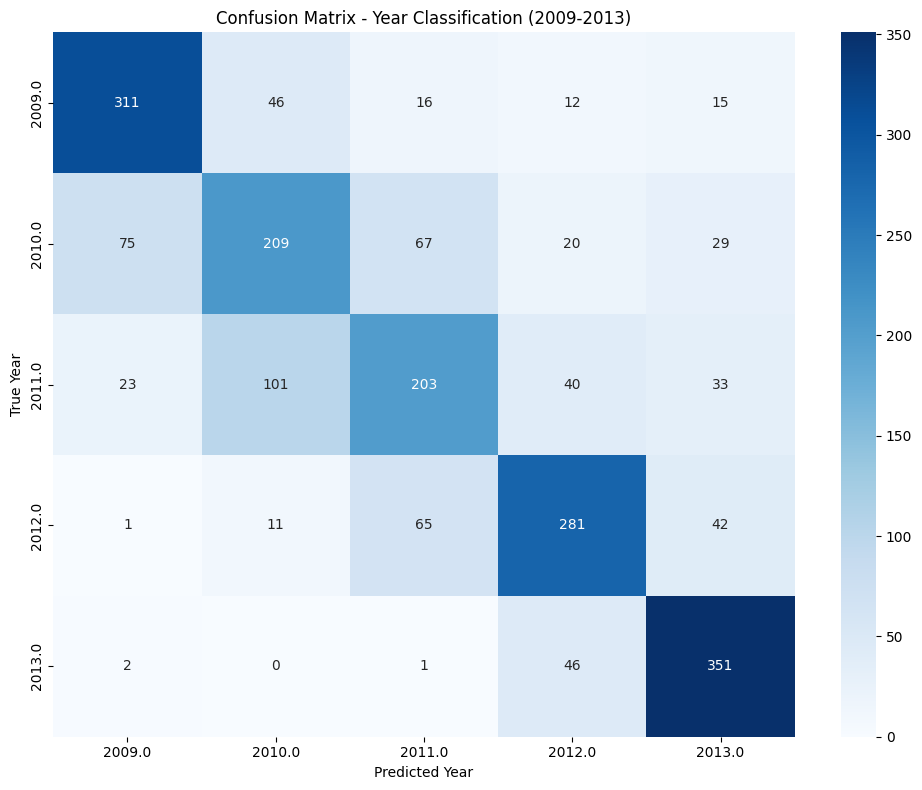

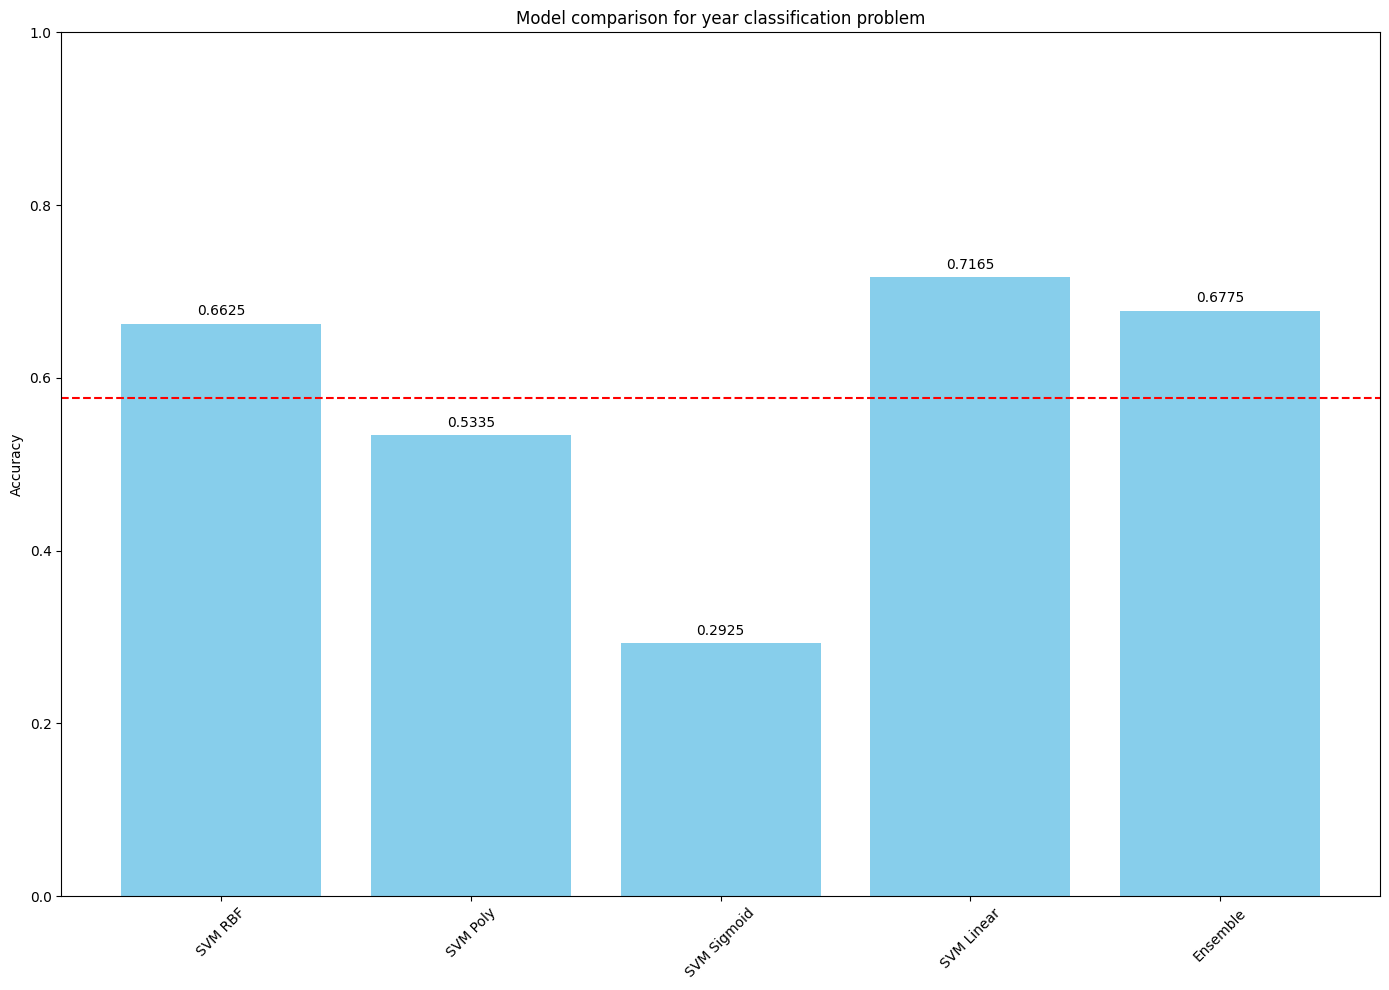

In [15]:
model_exp_6 = train_svm_experiment_5_6(X_5_6, y_5_6, use_ensemble=True)
save_model_joblib(model, 'svm_model_exp6_years.joblib')

Optional (important for while we were developing the model, etc.): find feature importance with PCA.

In [ ]:
print("Analyzing feature importance...")
top_features = analyze_feature_importance(model, X, y)
print("Top 5 features:")
for feature, importance in top_features[:5]:
    print(f"- {feature}: {importance:.4f}")

Analyzing feature importance...


Just for the visual - project to 2D and display decision boundaries.

In [ ]:
print("Visualizing decision boundaries...")
visualize_kernel_decision_boundary(model, X, y)
print("Done!")

Visualizing decision boundaries...
